In [1]:
cd ..

/home/mars/mount/src_aiai


In [2]:
import tqdm 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from scipy.special import iv, jv
from scipy.sparse import *

In [4]:
import sparse

In [5]:
from src.sampling.uv_sampling import spider_sampling

In [6]:
from src.operators.measurement import NUFFT_op

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [7]:
from pynufft import NUDFT

In [8]:
uv = spider_sampling()

In [9]:
nufft = NUFFT_op(uv)

In [10]:
Nd = (256,256)
Kd = (512, 512)
Jd = (6,6)

## KB coefficients

In [11]:
gridsize = 2*np.pi / Kd[0]
k = (uv + np.pi) / gridsize
kx = (uv[:,0] + np.pi) // gridsize
ky = (uv[:,1] + np.pi) // gridsize

In [12]:
def calculate_coef(k, i, Jd=(6,6)):
    k = k.reshape(-1,1)
    J = Jd[0]//2
    a = np.array(np.meshgrid(range(-J, J), range(-J, J))).reshape(2, -1)
    a += (k % 1 >0.5) # corrects to the closest 6 pixels
    indices = (k.astype(int) + a)

    J = Jd[0]# np.linalg.norm(Jd) # composite J

    beta = 2.34*J
    norm = J #iv(0, beta) # TODO figure out which norm

#     u = np.linalg.norm(k.reshape(2,1) - indices, axis=0) # 2d distance
#     values = iv(0, beta*np.sqrt(1 +0j - (4*u/Jd[0])**2)).real / norm # 1/4 J because (sqrt((1/2 J)^2 + (1/2 J)^2 )= 1/4J)

    u =  k.reshape(2,1) - indices
    values1 = iv(0, beta*np.sqrt(1 +0j - (2*u[0]/Jd[0])**2)).real / norm # 1/4 J because (sqrt((1/2 J)^2 + (1/2 J)^2 
    values2 = iv(0, beta*np.sqrt(1 +0j - (2*u[1]/Jd[0])**2)).real / norm # 1/4 J because (sqrt((1/2 J)^2 + (1/2 J)^2 
    values = values1 * values2
    
    indices = np.vstack((np.zeros(indices.shape[1]), np.repeat(i, indices.shape[1]), indices[0], indices[1])).astype(int)

    return indices.T, values

In [13]:
c = calculate_coef(k[0], 0)

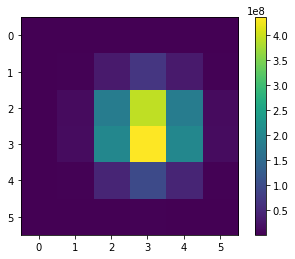

In [14]:
plt.imshow(c[-1].reshape(6,6))
plt.colorbar()

## NUFFT Operator

In [15]:
class Op():
    def __init__(self):
        pass
        # TODO select axes over which to perform fft (and padding operations)
        # TODO add scaling 
        # TODO check coeficient calculation
        
    def plan(self, uv, Nd, Kd, Jd):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        indices = np.array(indices).reshape(-1, 4)
        values = np.array(values).reshape(-1)
        self.interp_matrix = sparse.COO(indices.T, values, shape=(1, len(uv), Kd[0], Kd[1]))
    
        J = Jd[0] #np.linalg.norm(Jd)
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        xx = (np.arange(Kd[0])/Kd[0] -.5)[Kd[0]//4:-Kd[0]//4]
        sa = s_kb(xx).real
        self.scaling = (sa.reshape(-1,1) * sa.reshape(1,-1))
#         self.scaling = 1

    def forward(self, xx):
        return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx/self.scaling).reshape(-1, self.Nd[0], self.Nd[1])))))  # why divide on both sides?
#         return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx).reshape(-1, self.Nd[0], self.Nd[1]))*self.scaling))) 
    
    def adjoint(self, k):
        return np.squeeze(self._unpad(self._kk2xx(self._k2kk(k)))) / self.scaling
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return (self.interp_matrix * kk.reshape(-1, 1, self.Kd[0], self.Kd[1])).sum(axis=(2,3)).todense()
    
    def _k2kk(self, y):
        """convolutes measurements to oversampled fft grid"""
        return (self.interp_matrix * y.reshape(-1, self.M, 1, 1)).sum(axis=1).todense()
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(kk, axes=(-2,-1)), axes=(-2,-1), norm=None), axes=(-2,-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(xx, axes=(-2,-1)), axes=(-2,-1), norm=None), axes=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return np.pad(x, (
            ( 0,0 ),
            ( (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2),
            ( (self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2)
            ))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] # remove zero padding from image

In [16]:
op = Op()
op.plan(uv, Nd=(256,256), Kd=(512,512), Jd=(6,6))

100%|██████████| 4440/4440 [00:00<00:00, 5332.65it/s]


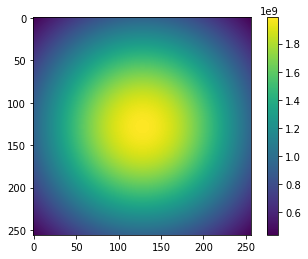

In [17]:
plt.imshow(op.scaling.real)
plt.colorbar()

In [275]:
op.interp_matrix.shape

(1, 4440, 512, 512)

## test operator



In [56]:
def dft(x, w, m):
    
    return np.array([np.sum(m * np.exp(1j*w*i)) for i in x ])

def dft2(x1, x2, w, m):
   
    w1 = np.exp(1j * w[:,0])
    w2 = np.exp(1j * w[:,1])
    N = len(x1)
    res = np.zeros((len(x1), len(x2)))
    for i in tqdm.tqdm(range(len(x1))):
        for j in range(len(x2)):
            res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
    return res/(2*N)**2

In [20]:
res = dft2(np.arange(-128,128), np.arange(-128,128), uv, np.ones(len(uv)))

  0%|          | 0/256 [00:00<?, ?it/s]<ipython-input-19-2d6e30a2d649>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
100%|██████████| 256/256 [00:49<00:00,  5.13it/s]


### ndft

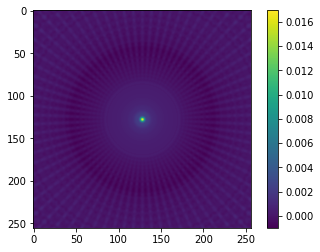

In [23]:
plt.imshow(res)
plt.colorbar()

### pynufft

In [234]:
%%time

x_dirty_2 = nufft.adj_op(np.ones((4440,1)))
# x_dirty_2 = nufft.adj_op((y))

CPU times: user 10.8 ms, sys: 1.01 ms, total: 11.8 ms
Wall time: 12.8 ms


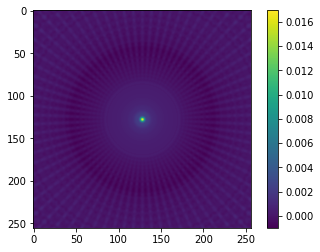

In [46]:
plt.imshow(x_dirty_2.real)
plt.colorbar()

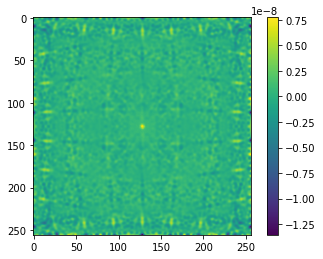

In [26]:
plt.imshow(res - x_dirty_2.real)
plt.colorbar()

In [78]:
f"rms {np.sqrt(np.mean(np.square(res - x_dirty_2.real))):.3e}"

'1.092e-09'

### myNUFFT

In [18]:
%%time
x_dirty = op.adjoint(np.ones((4440,1)))
# y = op.forward(np.ones((256,256)))
# x_dirty = op.adjoint((y))

CPU times: user 427 ms, sys: 25.1 ms, total: 452 ms
Wall time: 1.18 s


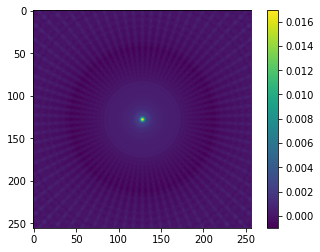

In [19]:
norm = 1#Kd[0] # correct for normalisation (sqrt(K**2))
plt.imshow(x_dirty.real/(norm))
plt.colorbar()

In [20]:
plt.imshow(x_dirty.real/(norm) - res)
plt.colorbar()

NameError: name 'res' is not defined

In [ ]:
f"rms {np.sqrt(np.mean(np.square(x_dirty.real/(norm) - res))):.3e}"

In [321]:
y1 = nufft.dir_op(np.ones((256,256)))
x1 = nufft.adj_op(y1)

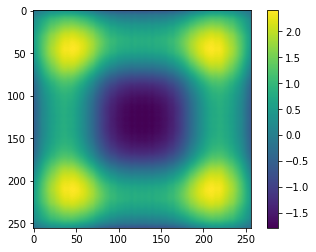

In [322]:
plt.imshow(x1.real)
plt.colorbar()

In [329]:
y2 = op.forward(np.ones((256,256)))
x2 = op.adjoint(y2)

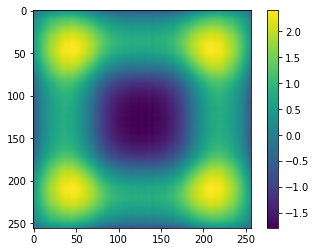

In [330]:
plt.imshow(x2.real)
plt.colorbar()

In [ ]:
y1

/home/mars/Documents/src_aiai/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


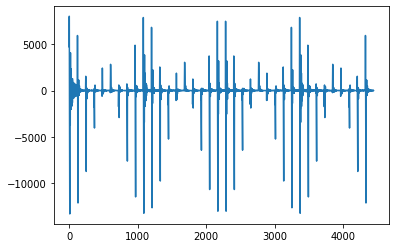

In [326]:
plt.plot(y1)

/home/mars/Documents/src_aiai/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


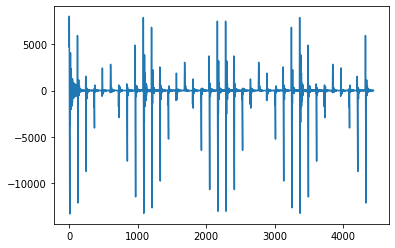

In [328]:
a = np.ones((256,256))
y2 = op.forward(a)
plt.plot(y2)

## TF numpyfunc

In [21]:
import tensorflow as tf

In [22]:
forward = lambda x: tf.numpy_function(op.forward, [x], tf.complex128)
adjoint = lambda x: tf.numpy_function(op.adjoint, [x], tf.complex128)

In [23]:
def gradient(x, y):
    m = forward(x)
#     print(m)
    res = m - y
#     print(res)
    return tf.cast(adjoint(res), tf.float32)

In [24]:
a = tf.convert_to_tensor(np.ones((3,256,256,1)))
b = forward(a[:,:,:,0])
c = adjoint(b)

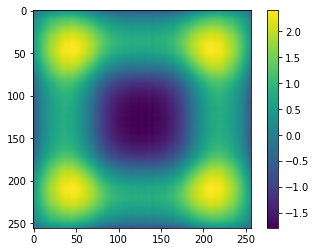

In [25]:
plt.imshow(c.numpy()[0].real)
plt.colorbar()

In [26]:
g = gradient(c,b).numpy()

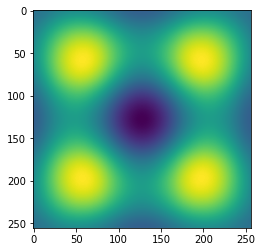

In [27]:
plt.imshow(g[0])

In [28]:
input_shape =(256,256,1)

In [29]:
inputs = tf.keras.Input(input_shape)
measurements = forward(inputs[:,:,:,0])

x = inputs

# grad = gradient(x[:,:,:,0], measurements)
# grad.set_shape([None,256,256])
# x = tf.keras.layers.Concatenate()([x,grad[:,:,:, None]])

x = tf.keras.layers.Conv2D(
            filters=4, 
            kernel_size=3, 
            activation='relu', 
            padding='same',
            name="conv2d_down_depth" )(x)

# output formatting
outputs = tf.keras.layers.Conv2D(
            filters=1, 
            kernel_size=1, 
            padding='same',
            activation='linear',
            name="conv2d_output"
            )(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss= tf.keras.losses.MSE)

In [30]:
inputs = tf.keras.Input(input_shape)
measurements = forward(inputs[:,:,:,0])

x = inputs

grad = gradient(x[:,:,:,0], measurements)
grad.set_shape([None,256,256])
x = tf.keras.layers.Concatenate()([x,grad[:,:,:, None]])

x = tf.keras.layers.Conv2D(
            filters=4, 
            kernel_size=3, 
            activation='relu', 
            padding='same',
            name="conv2d_down_depth" )(x)

# output formatting
outputs = tf.keras.layers.Conv2D(
            filters=1, 
            kernel_size=1, 
            padding='same',
            activation='linear',
            name="conv2d_output"
            )(x)

grad_model = tf.keras.Model(inputs=inputs, outputs=outputs)

grad_model.compile(optimizer='adam', loss= tf.keras.losses.MSE)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_down_depth (Conv2D)   (None, 256, 256, 4)       40        
_________________________________________________________________
conv2d_output (Conv2D)       (None, 256, 256, 1)       5         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


In [32]:
grad_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 256, 256)     0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 256, 256)     0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.numpy_function_2 (TFOpLambda None                 0           tf.__operators__.getitem_2[0][0] 
____________________________________________________________________________________________

In [33]:
def load_data(data_folder, ISNR=30):
    """load the pre-computed train and test data"""
    fft = lambda x: np.fft.fftshift(np.fft.fft2(
        np.fft.fftshift(x, axes=(1,2)), axes=(1,2), norm='ortho'), axes=(1,2))

    print("Loading train data")
    x_true = np.load(data_folder+ f"/x_true_train_{ISNR}dB.npy")
    x_dirty = np.load(data_folder+ f"/x_dirty_train_{ISNR}dB.npy")
    # y_dirty = np.load(project_folder + f"./data/intermediate/{data}/y_dirty_train_{ISNR}dB.npy").reshape( 200,4440)
    


    return x_true, x_dirty


In [34]:
x_true, x_dirty = load_data("./data/intermediate/BSDS/", 50)


Loading train data


In [35]:
model.fit((x_dirty), x_true, epochs=5)

Epoch 1/5
7/7 [==============================] - 2s 182ms/step - loss: 0.2387
Epoch 2/5
7/7 [==============================] - 1s 187ms/step - loss: 0.2185
Epoch 3/5
7/7 [==============================] - 1s 180ms/step - loss: 0.1992
Epoch 4/5
7/7 [==============================] - 1s 180ms/step - loss: 0.1940
Epoch 5/5
7/7 [==============================] - 1s 176ms/step - loss: 0.1793


In [36]:
grad_model.fit((x_dirty), x_true, epochs=5)

Epoch 1/5
7/7 [==============================] - 19s 3s/step - loss: 0.2477
Epoch 2/5
7/7 [==============================] - 20s 3s/step - loss: 0.2384
Epoch 3/5
7/7 [==============================] - 20s 3s/step - loss: 0.2144
Epoch 4/5
7/7 [==============================] - 20s 3s/step - loss: 0.2064
Epoch 5/5
7/7 [==============================] - 19s 3s/step - loss: 0.1906


In [ ]:
# with gradient: 3s/32
# without gradient: 163ms/32

In [300]:
class Op_tf():
    def __init__(self):
        pass
        # TODO select axes over which to perform fft (and padding operations)
        # TODO add scaling 
        # TODO check coeficient calculation
        
    def plan(self, uv, Nd, Kd, Jd, batch_size):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        # repeating the values and indices to match the batch_size (con of sparse tensors)
        indices = np.array(indices).reshape(-1, 4)
        batch_indices = np.tile(indices[:,1:], [batch_size, 1])
        batch_indicators = np.repeat(np.arange(batch_size), (len(values)))
        batch_indices = np.hstack((batch_indicators[:,None], batch_indices))

        values = np.array(values).reshape(-1)
        batch_values = np.tile(values, batch_size)

#         self.interp_matrix = sparse.COO(indices.T, values, shape=(1, len(uv), Kd[0], Kd[1]))
        self.interp_matrix = tf.sparse.SparseTensor(batch_indices, batch_values, [batch_size, len(uv), Kd[0], Kd[1]])
    
        J = Jd[0] #np.linalg.norm(Jd)
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        xx = (np.arange(Kd[0])/Kd[0] -.5)[Kd[0]//4:-Kd[0]//4]
        sa = s_kb(xx).real
        self.scaling = (sa.reshape(-1,1) * sa.reshape(1,-1)).reshape(1, Nd[0], Nd[0])
#         self.scaling = 1

    def forward(self, xx):
        xx = tf.cast(xx, tf.complex128)
        xx = xx/self.scaling
        xx = self._pad(xx)
        
        kk = self._xx2kk(xx)
        
        kk = kk[:, None, :, :] # adding axes for sparse multiplication; shape [batch_size, 1, K, K]
        # split real and imaginary parts because complex operations not defined for sparseTensors
        k_real = tf.cast(self._kk2k(tf.math.real(kk)), tf.complex128)
        k_imag = tf.cast(self._kk2k(tf.math.imag(kk)), tf.complex128)
        return k_real + 1j * k_imag
        
        
#         return (self._kk2k(self._xx2kk(self._pad((xx/self.scaling)))))  # why divide on both sides?
#         return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx).reshape(-1, self.Nd[0], self.Nd[1]))*self.scaling))) 
    
    def adjoint(self, k):
        # split real and imaginary parts because complex operations not defined for sparseTensors
        k = k[:,:, None, None] # adding axes for sparse multiplication; shape [batch_size, M, 1, 1]
        kk_real = tf.cast(self._k2kk(tf.math.real(k)), tf.complex128)
        kk_imag = tf.cast(self._k2kk(tf.math.imag(k)), tf.complex128)
        kk = kk_real + 1j* kk_imag
        xx = self._kk2xx(kk)
        xx = self._unpad(xx)
        xx = xx / self.scaling
        return xx
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return tf.sparse.reduce_sum(self.interp_matrix * kk, axis=(2,3))
            
    def _k2kk(self, k):
        """convolutes measurements to oversampled fft grid"""
        return tf.sparse.reduce_sum(self.interp_matrix * k, axis=1 )
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return tf.signal.ifftshift(tf.signal.ifft2d(tf.signal.ifftshift(kk, axes=(-2,-1))), axes=(-2,-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(xx, axes=(-2,-1))), axes=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
#         return x
        return tf.pad(x, tf.constant([
            [0, 0],
            [(self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2],
            [(self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2]
        ]))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
#         return x
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] # remove zero padding from image

In [301]:
100*20/1e3

2.0

In [302]:
tf.constant([
            [0, 0],
            [(Kd[0]-Nd[0])//2, (Kd[0]-Nd[0])//2],
            [(Kd[1]-Nd[1])//2, (Kd[1]-Nd[1])//2]
        ])

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[  0,   0],
       [128, 128],
       [128, 128]], dtype=int32)>

In [303]:
batch_size = 20

Nd, Kd = (256, 256), (512, 512)
# Nd, Kd = (128, 128), (256, 256)
# Nd, Kd = (64, 64), (128, 128)
i = 0
sel = np.linalg.norm(uv, axis=1) < np.pi/2**i
tfop = Op_tf()
tfop.plan(uv[sel], Nd, Kd, Jd, batch_size)

100%|██████████| 4440/4440 [00:00<00:00, 5428.62it/s]


In [305]:
tfop.ind

array([[   0,    0,  253,  259],
       [   0,    0,  254,  259],
       [   0,    0,  255,  259],
       ...,
       [  19, 4439,  244,  328],
       [  19, 4439,  245,  328],
       [  19, 4439,  246,  328]])

In [307]:
tfop.val[4440*36:]

array([6.07036366e+00, 2.65783605e+04, 3.76940039e+05, ...,
       2.29333574e+07, 1.02907242e+07, 6.95137280e+05])

In [299]:
np.repeat(np.arange(batch_size), 4440*36)

array([ 0,  0,  0, ..., 19, 19, 19])

In [277]:
np.tile(a, [batch_size, 1]).shape

(3196800, 3)

In [271]:
np.tile(np.arange(batch_size), (4400*36)).shape

(3168000,)

In [245]:
f"{1598400 * 64 /8:.3e}"

'1.279e+07'

In [246]:
inp = tf.convert_to_tensor(np.ones((batch_size,Nd[0], Nd[1])))

In [247]:
tf.__version__

'2.4.1'

In [308]:
%%time
a = tfop.forward(inp)

CPU times: user 1.73 s, sys: 216 ms, total: 1.95 s
Wall time: 1.75 s


In [315]:
a[-3]

<tf.Tensor: shape=(4440,), dtype=complex128, numpy=
array([ 4.72941328e+03+1.61551981e+02j,  8.03683941e+03+2.52131383e+02j,
        8.01748659e+03+2.32518485e+02j, ...,
        7.54182137e+00+3.14754561e+00j,  9.59263286e+00+3.77409254e+00j,
       -1.18215713e-01-4.40072230e-02j])>

In [309]:
%%time
b = tfop.adjoint(a)

CPU times: user 2.57 s, sys: 295 ms, total: 2.86 s
Wall time: 2.63 s


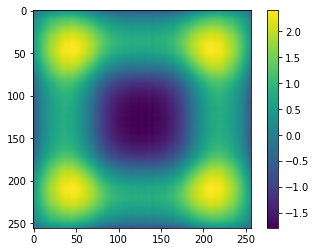

In [313]:
plt.imshow(b.numpy().real[-1])
plt.colorbar()

In [234]:
batch_values = np.tile(np.array(tfop.values).reshape(-1), batch_size)


In [212]:
np.array(tfop.values).shape

(4440, 36)

In [235]:
batch_values.shape

(3196800,)

In [242]:
batch_values[4440*36*2:]

array([6.07036366e+00, 2.65783605e+04, 3.76940039e+05, ...,
       2.29333574e+07, 1.02907242e+07, 6.95137280e+05])

In [228]:
b = tf.cast(a, tf.complex128)

In [144]:
b + 1j * b

<tf.Tensor: shape=(1, 4440), dtype=complex128, numpy=
array([[ 4.72941328e+03+4.72941328e+03j,  8.03683941e+03+8.03683941e+03j,
         8.01748659e+03+8.01748659e+03j, ...,
         7.54182137e+00+7.54182137e+00j,  9.59263286e+00+9.59263286e+00j,
        -1.18215713e-01-1.18215713e-01j]])>

In [114]:
tf.size(tfop.interp_matrix)

<tf.Tensor: shape=(), dtype=int32, numpy=1163919360>

In [118]:
tf.broadcast_to(tfop.interp_matrix, [10,4440, 512,512])

ValueError: Attempt to convert a value (<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7f302131bd30>) with an unsupported type (<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>) to a Tensor.

In [117]:
f"{1163919360*32 / 8:.3e}" # 4.7Gb

'4.656e+09'

In [111]:
a = tf.convert_to_tensor(np.ones((10,512,512)))

In [113]:
tf.sparse.map_values(tf.multiply, tfop.interp_matrix,  a)

InvalidArgumentError: Incompatible shapes: [159840] vs. [10,512,512] [Op:Mul]

In [102]:
indices = [
    [0,0,0],
    [1,1,1],
]

values = [1,2]
dense_shape = [2,3,3]

In [103]:
a = tf.sparse.SparseTensor(indices, values, dense_shape)

In [111]:
b = tf.convert_to_tensor(3*np.ones((3,3),dtype=np.int32))

In [122]:
op.interp_matrix.coords.shape

(4, 159840)

In [112]:
tf.sparse.to_dense(a)

<tf.Tensor: shape=(2, 3, 3), dtype=int32, numpy=
array([[[1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 2, 0],
        [0, 0, 0]]], dtype=int32)>

In [113]:
tf.sparse.to_dense(a*b)

<tf.Tensor: shape=(2, 3, 3), dtype=int32, numpy=
array([[[3, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 6, 0],
        [0, 0, 0]]], dtype=int32)>

In [134]:
indices = op.interp_matrix.coords
values = op.interp_matrix.data
dense_shape = op.interp_matrix.shape

In [135]:
indices.shape, values.shape, dense_shape

((4, 159840), (159840,), (1, 4440, 512, 512))

In [136]:
values

array([-0.01236364, -0.00135298, -0.01566847, ..., -0.00369519,
       -0.00692111,  0.00567517])

In [138]:
a = tf.sparse.SparseTensor(indices.T, values, dense_shape)

In [140]:
b = tf.convert_to_tensor(np.ones((512,512),dtype=float))

In [145]:
c = tf.sparse.reduce_sum(a*b, axis=1)

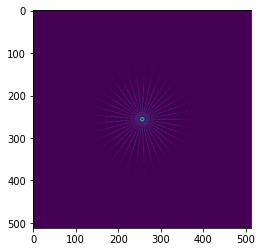

In [151]:
plt.imshow(c.numpy()[0])

# Kernels

In [65]:
beta = 2.34*Jd[0]
kb = lambda u: iv(0, beta*np.sqrt(1-(2*u/J)**2+0j)) / iv(0, beta)

sigma = 0.31* J**0.52
ga = lambda u: np.exp(-u**2/(2*sigma**2))

N = 1
sinc = lambda u: (u*np.pi/N)**-1 * np.sin(u*np.pi/N)

/home/mars/Documents/src_aiai/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


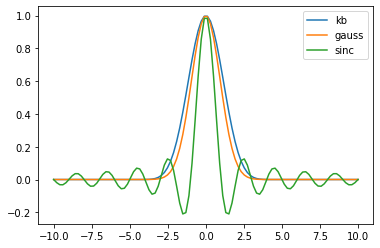

In [66]:
urange = np.linspace(-10,10, 100)
plt.plot(urange, kb(urange), label='kb')
plt.plot(urange, ga(urange), label='gauss')
plt.plot(urange, sinc(urange), label='sinc')
plt.legend()

8.48528137423857

In [91]:
cga = lambda x: (np.pi /(2*sigma**2))**-0.5 * np.exp(2 * np.pi**2 * x**2 * sigma**2)
ckb = lambda x: np.sinc( np.sqrt(np.pi**2 * x**2 * Jd[0]**2 - beta**2 +0j) / np.pi)**-1

In [120]:
m = 0
d = 1
J = 6
beta = 2.34*J
nu = d/2 + m

z = lambda u: np.sqrt((np.pi*J*u)**2 - beta**2+0j)
L = lambda z: (z/2)**(-nu) * jv(nu, z)
s = lambda u: (1/2)**m * np.pi**(d/2) * (J/2)**d * beta**m * L(z(u))/iv(m, beta)

/home/mars/Documents/src_aiai/env/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


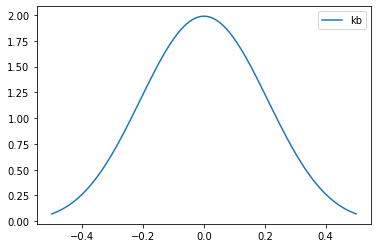

In [121]:
# xrange = np.linspace(-256, 256, 100)
xrange = np.linspace(-.5, .5, 100)

# plt.plot(xrange, ckb(xrange), label='kb')
plt.plot(xrange, s(xrange), label='kb')

# plt.plot(xrange, cga(xrange), label='gauss')
# plt.plot(xrange, sinc(xrange), label='sinc')
plt.legend()

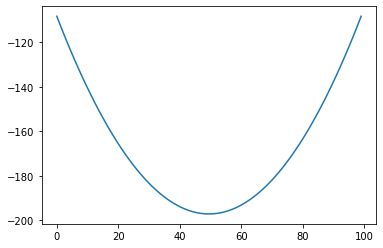

In [89]:
plt.plot(np.pi**2 * xrange**2 * Jd[0]**2 - beta**2)

In [88]:

np.sinc(np.sqrt( xrange**2 * Jd[0]**2 - beta**2 +0j ))

array([5.99840692e+16+0.j, 6.24476316e+16+0.j, 6.49566310e+16+0.j,
       6.75086621e+16+0.j, 7.01011259e+16+0.j, 7.27312306e+16+0.j,
       7.53959939e+16+0.j, 7.80922463e+16+0.j, 8.08166349e+16+0.j,
       8.35656282e+16+0.j, 8.63355217e+16+0.j, 8.91224444e+16+0.j,
       9.19223665e+16+0.j, 9.47311068e+16+0.j, 9.75443426e+16+0.j,
       1.00357619e+17+0.j, 1.03166359e+17+0.j, 1.05965877e+17+0.j,
       1.08751388e+17+0.j, 1.11518022e+17+0.j, 1.14260837e+17+0.j,
       1.16974833e+17+0.j, 1.19654967e+17+0.j, 1.22296168e+17+0.j,
       1.24893350e+17+0.j, 1.27441431e+17+0.j, 1.29935349e+17+0.j,
       1.32370075e+17+0.j, 1.34740632e+17+0.j, 1.37042113e+17+0.j,
       1.39269692e+17+0.j, 1.41418648e+17+0.j, 1.43484374e+17+0.j,
       1.45462399e+17+0.j, 1.47348398e+17+0.j, 1.49138215e+17+0.j,
       1.50827870e+17+0.j, 1.52413579e+17+0.j, 1.53891763e+17+0.j,
       1.55259068e+17+0.j, 1.56512371e+17+0.j, 1.57648794e+17+0.j,
       1.58665714e+17+0.j, 1.59560777e+17+0.j, 1.60331899e+17+